# エンコーダを学習する

__Contents:__

- <a href="#raw2feat">視覚刺激から特徴量を造る</a>
- <a href="#algorun">モデルを初期化してアルゴリズムを走らせる</a>
- <a href="#eval">学習機の出来を評価する</a>

___

ここでの目的は、これまでに習得してきた技法や知見を融合させ、正常に機能する学習機を造ることである。その応用先は視覚刺激から脳活動へのエンコーディングである。

作業の流れは下記の通りになる：

    視覚刺激の読み込み --> ガボールフィルタで特徴量を作って保存 --> スパースな線形回帰

これらのタスクを一つずつこなしていく。やり方を明確に伝えるべく、非常に単純なプロトタイプを作っておく。その後の課題では、このプロトタイプをベースにして、エンコーダとしてちゃんと機能するように改善してもらうことになる。

<a id="raw2feat"></a>
## 視覚刺激から特徴量を造る

In [1]:
import numpy as np
import math
import tables
import helpers as hlp

In [2]:
# Establish connection with the file objects.
h5_X = tables.open_file("data/vim-2/stimulus_ds.h5", mode="r")
print(h5_X)

data/vim-2/stimulus_ds.h5 (File) 'vim-2: stimulus'
Last modif.: 'Tue Mar 27 21:14:47 2018'
Object Tree: 
/ (RootGroup) 'vim-2: stimulus'
/test (Array(64, 64, 3, 8100)) 'Testing data'
/train (Array(64, 64, 3, 108000)) 'Training data'



In [3]:
# Set up the parameters that specify the first filter bank.
PIX_W = 64
PIX_H = 64
max_cycles = 32 # the maximum cycles per image.
myparas = {"freqs": max_cycles/max(PIX_W,PIX_H),
           "dir": 0,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mygrid_h = 4
mygrid_w = 4

In [4]:
# Construct features using the specified filter bank (TRAINING).
X_tr = hlp.G2_getfeatures(ims=h5_X.root.train.read(),
                          fil_paras=myparas,
                          gridshape=(mygrid_h, mygrid_w),
                          mode="reflect", cval=0, verbose=True)
print(X_tr.shape)

Images processed so far: 0
Images processed so far: 2160
Images processed so far: 4320
Images processed so far: 6480
Images processed so far: 8640
Images processed so far: 10800
Images processed so far: 12960
Images processed so far: 15120
Images processed so far: 17280
Images processed so far: 19440
Images processed so far: 21600
Images processed so far: 23760
Images processed so far: 25920
Images processed so far: 28080
Images processed so far: 30240
Images processed so far: 32400
Images processed so far: 34560
Images processed so far: 36720
Images processed so far: 38880
Images processed so far: 41040
Images processed so far: 43200
Images processed so far: 45360
Images processed so far: 47520
Images processed so far: 49680
Images processed so far: 51840
Images processed so far: 54000
Images processed so far: 56160
Images processed so far: 58320
Images processed so far: 60480
Images processed so far: 62640
Images processed so far: 64800
Images processed so far: 66960
Images processed

In [5]:
# Construct features using the specified filter bank (TESTING).
X_te = hlp.G2_getfeatures(ims=h5_X.root.test.read(),
                          fil_paras=myparas,
                          gridshape=(mygrid_h, mygrid_w),
                          mode="reflect", cval=0, verbose=True)
print(X_te.shape)

Images processed so far: 0
Images processed so far: 162
Images processed so far: 324
Images processed so far: 486
Images processed so far: 648
Images processed so far: 810
Images processed so far: 972
Images processed so far: 1134
Images processed so far: 1296
Images processed so far: 1458
Images processed so far: 1620
Images processed so far: 1782
Images processed so far: 1944
Images processed so far: 2106
Images processed so far: 2268
Images processed so far: 2430
Images processed so far: 2592
Images processed so far: 2754
Images processed so far: 2916
Images processed so far: 3078
Images processed so far: 3240
Images processed so far: 3402
Images processed so far: 3564
Images processed so far: 3726
Images processed so far: 3888
Images processed so far: 4050
Images processed so far: 4212
Images processed so far: 4374
Images processed so far: 4536
Images processed so far: 4698
Images processed so far: 4860
Images processed so far: 5022
Images processed so far: 5184
Images processed so

これで出来上がった特徴量は、ある一つだけのガボールフィルタの下でできたものである。空間周波数に着目すると、上記ではその値をゼロとしているが、ほかの値もまんべんなく反映すべきであろう。実際、Nishimoto *et al.* (2011)で試される手法のうち、"static model"が我々が実装しているものにきわめて近い。ただし、彼らのモデルでは、フィルタの向きが"0, 45, 90 and 135 degrees"（appendixより引用）とある。0度の場合は済んでいるので、残りを用意しておこう。

In [6]:
todo_dir = math.pi * np.array([1,2,3]) / 4

for mydir in todo_dir:
    print("Adding features using dir =", mydir*(360/(2*math.pi)), "degrees")
    myparas["dir"] = mydir
    
    tmp_X = hlp.G2_getfeatures(ims=h5_X.root.train.read(),
                               fil_paras=myparas,
                               gridshape=(mygrid_h, mygrid_w),
                               mode="reflect", cval=0, verbose=False)
    X_tr = np.concatenate((X_tr, tmp_X), axis=1)
    
    tmp_X = hlp.G2_getfeatures(ims=h5_X.root.test.read(),
                               fil_paras=myparas,
                               gridshape=(mygrid_h, mygrid_w),
                               mode="reflect", cval=0, verbose=False)
    X_te = np.concatenate((X_te, tmp_X), axis=1)
    

Adding features using dir = 45.0 degrees
Adding features using dir = 90.0 degrees
Adding features using dir = 135.0 degrees


In [7]:
# All finished with this file, so close it.
h5_X.close()
print(h5_X)

<closed File>


次に時間軸におけるダウンサンプリングが必要である。応答信号は一秒に一度のペースで観測しているのに対して、視覚刺激の入力は一秒に15枚もある。15フレームおきにこの時系列を分割して、平均を取るという形で望ましいデータ数に縮約する。

In [8]:
framerate = 15
n_tr = X_tr.shape[0]//framerate
n_te = X_te.shape[0]//framerate
print(n_tr)
print(n_te)

7200
540


In [9]:
# Training data.
tmp_X = np.zeros((n_tr,X_tr.shape[1]), dtype=X_tr.dtype)
idx = np.arange(framerate)
for i in range(n_tr):
    tmp_X[i,:] = np.mean(X_tr[idx,:], axis=0)
    idx += framerate
X_tr = tmp_X
print("X_tr shape after down-sampling:", X_tr.shape)

# Testing data.
tmp_X = np.zeros((n_te,X_te.shape[1]), dtype=X_te.dtype)
idx = np.arange(framerate)
for i in range(n_te):
    tmp_X[i,:] = np.mean(X_te[idx,:], axis=0)
    idx += framerate
X_te = tmp_X
print("X_te shape after down-sampling:", X_te.shape)

X_tr shape after down-sampling: (7200, 64)
X_te shape after down-sampling: (540, 64)


また、Nishimoto et al. (2011)にしたがって、特徴量のZスコアを用いることにする。記号で表わすと：

\begin{align}
z = \frac{x - \bar{x} }{\sqrt{\widehat{v}}}
\end{align}

ここで$\bar{x}$が経験平均、$\widehat{v}$が経験分散である。

In [13]:
# Z-scores
Z_tr = X_tr - np.mean(X_tr, axis=0)
Z_tr = Z_tr / np.std(Z_tr, axis=0)
#print("Mean =", np.mean(Z_tr, axis=0), "StdDev =", np.std(Z_tr, axis=0))
Z_te = X_te - np.mean(X_te, axis=0)
Z_te = Z_te / np.std(Z_te, axis=0)
#print("Mean =", np.mean(Z_te, axis=0), "StdDev =", np.std(Z_te, axis=0))

さらに、標準偏差の3倍を超えた値を外れ値と見なして、切断する。学習課題の公平性を保つため、訓練データと検証データを別々に扱う。

In [14]:
# Truncation of outliers.
thres = 3
for j in range(X_tr.shape[1]):
    stdval = np.std(Z_tr[:,j])
    Z_tr[:,j] = np.clip(Z_tr[:,j], a_min=(-thres*stdval), a_max=thres*stdval)
    stdval = np.std(Z_te[:,j])
    Z_te[:,j] = np.clip(Z_te[:,j], a_min=(-thres*stdval), a_max=thres*stdval)

新しい階層型データファイル`features.h5`を作って、学習と検証用の特徴量を格納しておく。

In [15]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/vim-2/features.h5",
                        mode="w",
                        title="Features from vim-2 stimulus, via 2D Gabor filter bank")
print(myh5)

data/vim-2/features.h5 (File) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
Last modif.: 'Sat Apr  7 17:14:23 2018'
Object Tree: 
/ (RootGroup) 'Features from vim-2 stimulus, via 2D Gabor filter bank'



In [16]:
# Add arrays.
myh5.create_array(where=myh5.root, name="train", obj=Z_tr, title="Training data")
print(myh5)
myh5.create_array(where=myh5.root, name="test", obj=Z_te, title="Testing data")
print(myh5)

data/vim-2/features.h5 (File) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
Last modif.: 'Sat Apr  7 17:14:34 2018'
Object Tree: 
/ (RootGroup) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
/train (Array(7200, 64)) 'Training data'

data/vim-2/features.h5 (File) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
Last modif.: 'Sat Apr  7 17:14:34 2018'
Object Tree: 
/ (RootGroup) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
/test (Array(540, 64)) 'Testing data'
/train (Array(7200, 64)) 'Training data'



In [17]:
# Close the file connection.
myh5.close()
print(myh5)

<closed File>


#### MEMO for exercises:

0. Have them consider multiple *lags*, and multiple *spatial frequences*, precisely as in Nishimoto work.


___

<a id="algorun"></a>
## モデルを初期化してアルゴリズムを走らせる

特徴量の準備が整っているなら、Jupyterのカーネルをリセットし、ここから新たな作業を始める。


前回で作った`Algo_LASSO_CD`をここで本領発揮してもらう。前回のテストとまったく同様に、多数の$\lambda$候補を用意し、warm startを生かしながら学習させていく。パフォーマンス評価指標として、Nishimoto et al. (2011)より：

> *"Prediction accuracy was defined as the correlation between predicted and observed BOLD signals. The averaged accuracy across subjects and voxels in early visual areas (V1, V2, V3, V3A, and V3B) was 0.24, 0.39, and 0.40 for the static, nondirectional, and directional encoding models, respectively."*

教育目的なので我々の学習機があらゆる意味で彼らのものに劣っているのだが、めざす基準としてはこの数値には意義がある。特に相関係数0.24は、2次元のガボールフィルタを使ったときに出た数字なので、より現実的な基準と見てもよかろう。

算出方法は次の通りである。訓練データを使って、学習アルゴリズムを一通り走らせると、$\widehat{w}$に対応する`w_est`が定まる。線形モデルを使っているので、新しい入力$X$から$\widehat{y} = X\widehat{w}$を出して、$\widehat{y} \approx y$で近似してみる。この$X$と$y$が`X_te`と`y_te`に対応する。予測信号と本当の信号の相関が強いほどよいということなので、下記の通りに相関係数を出す：

\begin{align}
\text{corr}\,(\widehat{y},y) = \frac{\text{cov}\,(\widehat{y},y)}{\sqrt{\text{var}\,(\widehat{y})\text{var}\,(y)}},
\end{align}

これは`scipy.stats.pearsonr`で計算できる。また、予測・真の平均的な2乗誤差（root mean squared error; RMSE）を求めることもできる：

\begin{align}
\text{RMSE}\,(\widehat{y},y) = \left( \frac{1}{m} \sum_{i=1}^{m} (\widehat{y}_{i}-y_{i})^2 \right)^{1/2},
\end{align}

これはモデルオブジェクトの`mod.eval`というメソッドで実装している。$m$は検証データのサンプル数（ここでは$m=540$）。

In [1]:
import numpy as np
import math
import tables
import helpers as hlp

In [2]:
# Open file connections with data to be used in learning and evaluation.
h5_X = tables.open_file("data/vim-2/features.h5", mode="r")
print(h5_X)
h5_y = tables.open_file("data/vim-2/response.h5", mode="r")
print(h5_y)

data/vim-2/features.h5 (File) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
Last modif.: 'Sat Apr  7 17:14:42 2018'
Object Tree: 
/ (RootGroup) 'Features from vim-2 stimulus, via 2D Gabor filter bank'
/test (Array(540, 64)) 'Testing data'
/train (Array(7200, 64)) 'Training data'

data/vim-2/response.h5 (File) 'vim-2: BOLD responses'
Last modif.: 'Mon Apr  9 09:14:08 2018'
Object Tree: 
/ (RootGroup) 'vim-2: BOLD responses'
/sub1 (Group) 'Data for subject 1'
/sub2 (Group) 'Data for subject 2'
/sub3 (Group) 'Data for subject 3'
/sub3/idx (Group) 'ROI-specific voxel indices'
/sub3/idx/v1lh (Array(653,)) ''
/sub3/idx/v1rh (Array(713,)) ''
/sub3/idx/v2lh (Array(735,)) ''
/sub3/idx/v2rh (Array(642,)) ''
/sub3/idx/v3alh (Array(164,)) ''
/sub3/idx/v3arh (Array(118,)) ''
/sub3/idx/v3blh (Array(88,)) ''
/sub3/idx/v3brh (Array(138,)) ''
/sub3/idx/v3lh (Array(504,)) ''
/sub3/idx/v3rh (Array(627,)) ''
/sub3/resp (Group) 'Response arrays'
/sub3/resp/test (Array(4381, 540)) 'Testing data'


In [3]:
# Subject ID.
subid = 1
y_node = h5_y.get_node(h5_y.root, "sub"+str(subid))

# Number of voxels.
num_voxels = y_node.resp.train.nrows

# Set up the model and data objects.
mod = hlp.LeastSqL1()
data = hlp.Data()
data.X_tr = h5_X.root.train.read()
data.X_te = h5_X.root.test.read()

# Basic info.
n = data.X_tr.shape[0]
d = data.X_tr.shape[1]

# Dictionaries of performance over all voxels.
dict_corr_tr = {}
dict_corr_te = {}
dict_l0norm = {}

いよいよ主要の計算だけが待っている。相当な時間はかかるが、全ボクセル分の学習を下記の通りに行なうことができる。

In [ ]:
for voxidx in range(num_voxels):
    
    # Set up the responses.
    data.y_tr = np.transpose(np.take(a=y_node.resp.train.read(),
                                     indices=[voxidx],
                                     axis=0))
    data.y_te = np.transpose(np.take(a=y_node.resp.test.read(),
                                     indices=[voxidx],
                                     axis=0))

    # Set up for a loop over trials and lambda values.
    todo_lambda = np.logspace(start=math.log10(1/n), stop=math.log10(2.5), num=50)
    num_loops = 15
    t_max = num_loops * d
    
    # Storage for performance metrics.
    corr_tr = np.zeros(todo_lambda.size, dtype=np.float32)
    corr_te = np.zeros(todo_lambda.size, dtype=np.float32)
    l0norm = np.zeros(todo_lambda.size, dtype=np.uint32)
    
    # Initialize and run learning algorithm.
    w_init = 1*np.random.uniform(size=(d,1))

    for l in range(todo_lambda.size):

        lamval = todo_lambda[l]
        
        if (voxidx % 100 == 0) and (l == 0):
            print("Voxel:", voxidx+1, "of", num_voxels)
            #print("Lambda value =", lamval, "(", l, "of", todo_lambda.size, ")")

        # Use warm starts when available.
        if l > 0:
            w_init = al.w
        
        al = hlp.Algo_CDL1(w_init=w_init, t_max=t_max, lam_l1=lamval)

        # Iterate the learning algorithm.
        for mystep in al:
            al.update(model=mod, data=data)

        # Record performance based on final output.
        corr_tr[l] = hlp.corr(w=al.w, X=data.X_tr, y=data.y_tr)
        corr_te[l] = hlp.corr(w=al.w, X=data.X_te, y=data.y_te)
        l0norm[l] = np.nonzero(al.w)[0].size
    
    # Save the performance for this voxel.
    dict_corr_tr[voxidx] = corr_tr
    dict_corr_te[voxidx] = corr_te
    dict_l0norm[voxidx] = l0norm

Voxel: 1 of 4120
Voxel: 101 of 4120
Voxel: 201 of 4120
Voxel: 301 of 4120


実績をディスクに書き込んで保存する。

In [5]:
import pickle

# Method name
mthname = "DefaultMth"

# Lambda values used.
fname = "results/"+mthname+"sub"+str(subid)+".lam"
with open(fname, mode="bw") as fbin:
    pickle.dump(todo_lambda, fbin)

# Correlation over lambda values.
fname = "results/"+mthname+"sub"+str(subid)+".corrtr"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_corr_tr, fbin)
fname = "results/"+mthname+"sub"+str(subid)+"_vox"+str(voxidx)+".corrte"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_corr_te, fbin)

# Sparsity over lambda values.
fname = "results/"+mthname+"sub"+str(subid)+".l0norm"
with open(fname, mode="bw") as fbin:
    pickle.dump(dict_l0norm, fbin)

<a id="eval"></a>
## 学習機の出来を評価する

学習が終わって、あとは成績を集計したり、可視化したりするだけである。
Jupyterのカーネルをリセットし、ここから新たな作業を始める。

In [6]:
# Preparation.
import math
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import tables

In [7]:
# Method name
mthname = "DefaultMth"

# Subject ID.
subid = 1

# Lambda values used.
fname = "results/"+mthname+"sub"+str(subid)+".lam"
with open(fname, mode="br") as fbin:
    todo_lambda = pickle.load(fbin)

# Correlation over lambda values, on the training and test data.
fname = "results/"+mthname+"sub"+str(subid)+".corrtr"
with open(fname, mode="br") as fbin:
    dict_corr_tr = pickle.load(fbin)
fname = "results/"+mthname+"sub"+str(subid)+"_vox"+str(voxidx)+".corrte"
with open(fname, mode="br") as fbin:
    dict_corr_te = pickle.load(fbin)

# Sparsity over lambda values.
fname = "results/"+mthname+"sub"+str(subid)+".l0norm"
with open(fname, mode="br") as fbin:
    dict_l0norm = pickle.load(fbin)


まず、パフォーマンス指標をボクセルごとに見てみよう。

Results: subject 1 , voxel id 3


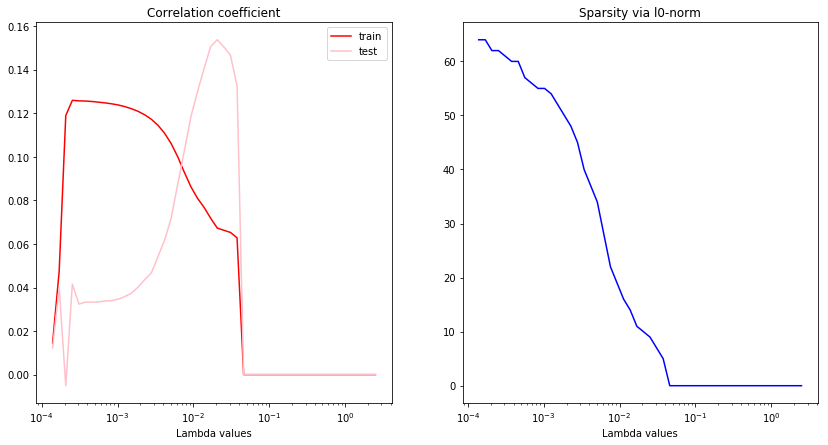

In [18]:
# Single-voxel performance evaluation.
voxidx = 3

print("Results: subject", subid, ", voxel id", voxidx)

myfig = plt.figure(figsize=(14,7))
ax_corr = myfig.add_subplot(1, 2, 1)
plt.title("Correlation coefficient")
plt.xlabel("Lambda values")
ax_corr.set_xscale('log')
ax_corr.plot(todo_lambda, dict_corr_tr[voxidx], label="train", color="red")
ax_corr.plot(todo_lambda, dict_corr_te[voxidx], label="test", color="pink")
ax_corr.legend(loc=1,ncol=1)

ax_spar = myfig.add_subplot(1, 2, 2)
plt.title("Sparsity via l0-norm")
plt.xlabel("Lambda values")
ax_spar.set_xscale('log')
ax_spar.plot(todo_lambda, dict_l0norm[voxidx], color="blue")

plt.show()

続いて、全ボクセルまで対象範囲を拡げ、ROIごとの平均的な成績を見ていく。まずは、$\lambda$の候補として多数の値を試しているので、代表的な成績を選ぶ必要がある。訓練、検証、それぞれにおいて相関係数の絶対値がもっとも高かったものを選出する。

In [19]:
num_voxels = len(dict_corr_tr)

best_corr_tr = np.zeros(num_voxels, dtype=np.float32)
best_corr_te = np.zeros(num_voxels, dtype=np.float32)

for v in range(num_voxels):
    
    # Best absolute correlation value.
    best_corr_tr[v] = np.max(np.abs(dict_corr_tr[v]))
    best_corr_te[v] = np.max(np.abs(dict_corr_te[v]))

次はROIの上でのループである。あらかじめ用意した階層型データはここで役に立つ。

In [20]:
dict_roi_corr_tr = {}
dict_roi_corr_te = {}

In [21]:
f = tables.open_file("data/vim-2/response.h5", mode="r")
tocheck = f.get_node(("/sub"+str(subid)), "idx")
for idxnode in tocheck._f_iter_nodes():
    idx = idxnode.read()
    roi_name = idxnode._v_name
    dict_roi_corr_tr[roi_name] = np.mean(best_corr_tr[idx])
    dict_roi_corr_te[roi_name] = np.mean(best_corr_te[idx])

f.close()

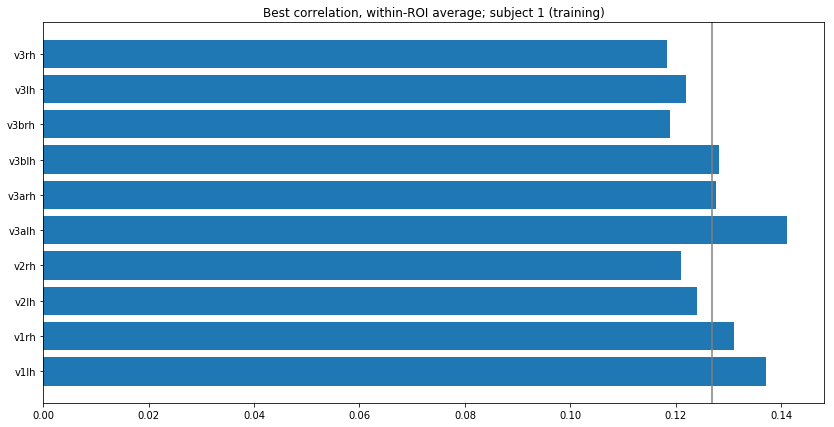

In [22]:
# Training
xvals = list(dict_roi_corr_tr.keys())
yvals = list(dict_roi_corr_tr.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(dict_roi_corr_tr)), yvals)
plt.yticks(range(len(dict_roi_corr_tr)), xvals)
plt.title("Best correlation, within-ROI average; subject "+ str(subid)+" (training)" )
plt.axvline(x=np.mean(np.array(yvals)), color="gray")
plt.show()

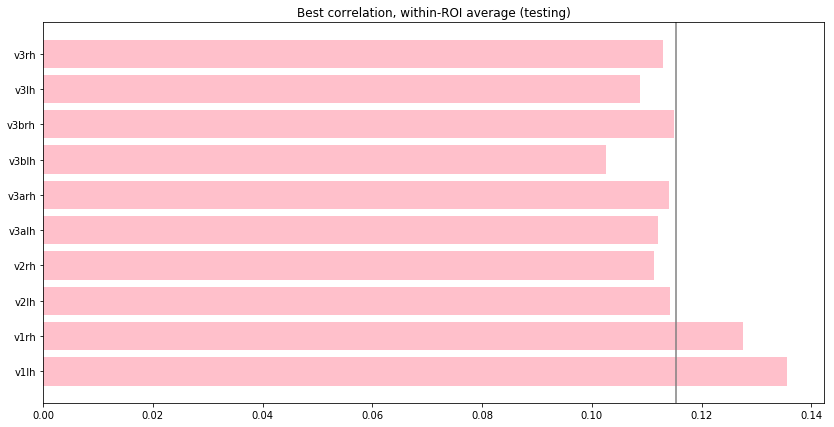

In [24]:
# Testing
xvals = list(dict_roi_corr_te.keys())
yvals = list(dict_roi_corr_te.values())
myfig = plt.figure(figsize=(14,7))
plt.barh(range(len(dict_roi_corr_te)), yvals, color="pink")
plt.yticks(range(len(dict_roi_corr_te)), xvals)
plt.title("Best correlation, within-ROI average (testing)")
plt.axvline(x=np.mean(np.array(yvals)), color="gray")
plt.show()

上記で作ったエンコーダには、改善する余地が山ほどある。というのも、特徴量が非常に少ないこと、学習アルゴリズムの設定が恣意的だったことなどを踏まえると、パラメータの設定をしっかりと詰めていくと大幅に改善できるはずである。注目すべき点としては、以下のものは用意に考えられる：

- 初期値`w_init`の決め方。

- $\lambda$の候補の範囲と密度。

- 学習機の反復回数の制限`t_max`。

- フィルタバンクを定めるあらゆるパラメータ(`myparas`の中身)が大事だが、特に重要なのは`freqs`、`dir`、`sdev`であろう。

- フィルタバンクの豊富さ。グリッドの解像度の高低、多様な空間周波数、向きなどをまんべんなく含むことが必須。

__種々の練習課題:__

0. すべてのボクセル分の学習をする必要はなく、Nishimoto et al.のいう「early visual areas」に焦点を当てること。それは両半球においてV1、V2、V3、V3A、V3BというROIのことを指す。訓練データを使い、これらの全ボクセル用のエンコーダを学習させ、検証データにおいて、訓練データでもっとも良かった$\lambda$のときの学習結果の成績を算出すること。ROIごとに、これらの成績（相関係数等）のボクセルの上での平均と分散を求めること（上ではすでにほぼ出来ている）。

0. 先の課題を、全被験者分のデータを使って行なうこと。被験者の間、同じモデルとアルゴリズムを使って、パフォーマンスに差異があるか。被験者の上でも平均的な成績を求めて、引用している論文の成績と勝負できるか。

0. 手法の更なる強化を測るため、時間の遅延を利用して特徴量を作ることができる。つまり、前の時点の特徴量ベクトルを、現時点の特徴量ベクトルに連結させるという方法。現時点の特徴量を$x_{i}$とすると、$x_{i-1}$が前の時点に相当するので、連結した結果が$\widetilde{x}_{i} = (x_{i},x_{i-1})$になって、この$\widetilde{x}_{i}$を学習に使うことになる。遅延が$k$時点なら、$\widetilde{x}_{i} = (x_{i},x_{i-1},\ldots,x_{i-k})$となる。数ステップを試して、パフォーマンスがもっとも良い遅延はいくらか。

0. 学習結果の良し悪しがROIによってどの程度変わるか。特段良い・悪い成績が見られたROIがあれば、それはどれか。

0. モデルは大事だが、学習アルゴリズムもきわめて大きな役割を果たす。ベストな設定を探るべく、反復回数などの終了条件や$\lambda$の候補範囲、その他のアルゴリズムの工夫を調べること。どのようなアルゴリズム設定がもっとも良い成績につながったか。独自の改造を行った場合、それも併せて説明すること。

0. これまでは同一被験者を前提として、「汎化能力」を評価してきた。当然ながら、被験者間の汎化能力も注目に値する。つまり、2名の被験者のデータを足し合わせて、大きなデータセットにまとめ、訓練データとして使って学習してから、残り1名の被験者のデータを検証データとする。同じモデルとアルゴリズムでも十分なのか。それとも、新たな工夫が必要だったか。また、このときの汎化能力の解釈が、被験者ごとに学習する場合と比べて、どう違うか。

## 参考文献：

 - Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.
 - Description of dataset vim-2 (visual imaging 2), at CRCNS - Collaborative Research in Computational Neuroscience. https://crcns.org/data-sets/vc/vim-2/about-vim-2